In [1]:
import pandas as pd
import numpy as np

clip_names = [
    "padel_tennis_neon_03-2ded8f56",  # mgg partner padel
    "padel_tennis_neon_01-b922b245", # mgg padel
    "2023-01-27_16-31-52-5f743ed0" # moritz snowboarding
]

iclip = 0

fn = "/users/tom/experiments/neon_blink_detection/datasets/train_data/%s/blinks.json" %clip_names[iclip]

df_cloud = pd.read_json(fn)

blink_df = pd.read_json("/users/tom/experiments/neon_blink_detection/datasets/train_data/%s/annotations-%s.json" %(clip_names[iclip], clip_names[iclip])).transpose()

blink_df["label"].replace(
            {
                "A": "onset",
                "B": "offset",
                "C": "onset",
                "D": "offset",
                "E": "clip_trigger",
                "F": "frame_trigger",
            },
            inplace=True,
        )

In [2]:
features_cloud = np.concatenate((np.load("/users/tom/features1.npy"), np.load("/users/tom/features2.npy")))

feature_array_cloud = np.concatenate((np.load("/users/tom/feature_array1.npy"), np.load("/users/tom/feature_array2.npy")))

proba_cloud = np.concatenate((np.load("/users/tom/proba1.npy"), np.load("/users/tom/proba2.npy")))

FileNotFoundError: [Errno 2] No such file or directory: '/users/tom/features1.npy'

In [12]:
import numpy as np
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path
from src.neon_blink_detector import detect_blinks
import typing as T
from helper import OfParams, PPParams, AugParams
from post_processing import post_process
from xgboost import XGBClassifier
from pathlib import Path
import joblib

video_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

def get_params() -> T.Tuple[OfParams, PPParams]:
    """Get optical flow parameters and post processing parameters."""

    of_params = OfParams(5, 7, False, (64, 64), 4, 7, 15, 3)
    pp_params = PPParams(
        max_gap_duration_s=0.03,
        short_event_min_len_s=0.1,
        smooth_window=11,
        proba_onset_threshold=0.25,
        proba_offset_threshold=0.25,
    )
    
    aug_params = AugParams()
    return of_params, pp_params

def get_classifier(clf_path: Path) -> XGBClassifier:
    """Get classifier with weights."""

    return joblib.load(str(clf_path))


from features_calculator import calculate_optical_flow, concatenate_features, new_concatenate_features, create_grids, extract_grid
from src.neon_blink_detector import detect_blinks
from utils import resize_images, rotate_images

of_params, pp_params = get_params()

aug_params = AugParams()

of_params.n_layers = 5
of_params.layer_interval = 7
of_params.grid_size = 4
of_params.window_size = 15

clf = get_classifier("/users/tom/git/pupil-cloud-pipeline/blink_detector/weights/xgb_neon.sav")

rec = video_loader(of_params, aug_params)
timestamps, images_left, images_right = rec._get_frames_pyav(clip_names[iclip], convert_to_gray=True)

grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)


proba = clf.predict_proba(features)
blink_events = post_process(timestamps, proba, pp_params)

TypeError: new_concatenate_features() missing 2 required positional arguments: 'n_clip_frames' and 'of_params'

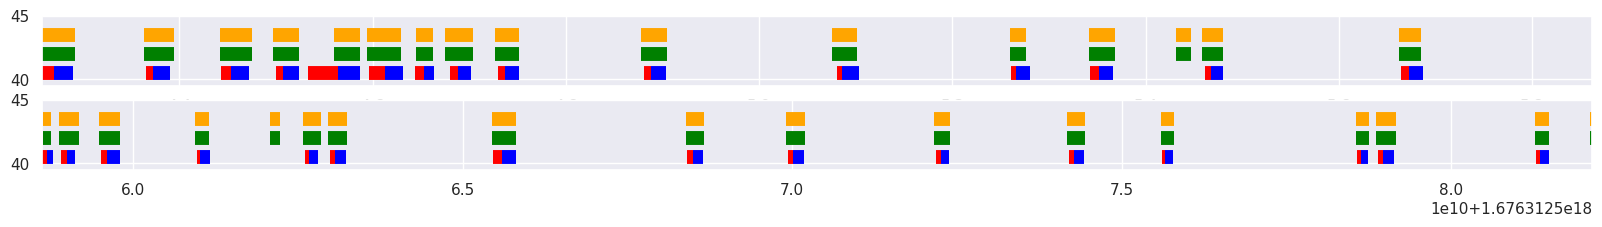

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

f, ax = plt.subplots(2, 1)
f.set_size_inches(20, 2)

on_start = blink_df[blink_df["label"]=="onset"]["start_ts"]
on_end = blink_df[blink_df["label"]=="onset"]["end_ts"]

off_start = blink_df[blink_df["label"]=="offset"]["start_ts"]
off_end = blink_df[blink_df["label"]=="offset"]["end_ts"]

blink_start = df_cloud["start_t"]
blink_end = df_cloud["end_t"]

clf_start_times = np.array([x.start_time for x in blink_events])
clf_end_time = np.array([x.end_time for x in blink_events])

for iplot in range(2):

    for i in range(len(on_start)):
        ax[iplot].hlines(40.5, on_start.iloc[i], on_end.iloc[i], alpha=1, color='red', lw=10)
        ax[iplot].hlines(40.5, off_start.iloc[i], off_end.iloc[i], alpha=1, color='blue', lw=10)

    for i in range(len(clf_start_times)):
        ax[iplot].hlines(43.5, clf_start_times[i], clf_end_time[i], alpha=1, color='orange', lw=10)

    for i in range(len(blink_start)):
        ax[iplot].hlines(42, blink_start.iloc[i], blink_end.iloc[i], alpha=1, color='green', lw=10)

    ax[iplot].set_xlim(on_start.iloc[int(15*iplot)],on_start.iloc[int(15*(iplot+1))])
    ax[iplot].set_ylim(39.5, 45)



In [31]:
len(np.isin(clf_start_times, blink_start.iloc[1:]))

52

In [30]:
len(clf_start_times)

52

In [36]:
left_flow_batch.shape

(10000, 16, 2)

In [7]:

import cv2
def test_create_grids(img_shape: T.Tuple[int, int], grid_size: int) -> np.ndarray:
    x = np.linspace(0, img_shape[1], grid_size + 2, dtype=np.float32)[1:-1]
    y = np.linspace(0, img_shape[0], grid_size + 2, dtype=np.float32)[1:-1]
    xx, yy = np.meshgrid(x, y)
    p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    return p_grid


def test_calculate_optical_flow(
    of_params: OfParams,
    left_images_curr: T.Sequence[np.ndarray],
    right_images_curr: T.Sequence[np.ndarray],
    left_images_prev: T.Sequence[np.ndarray] = None,
    right_images_prev: T.Sequence[np.ndarray] = None,
    grids: np.ndarray = None,
) -> np.ndarray:
    assert len(left_images_curr) == len(right_images_curr)
    n_frames = len(left_images_curr)
    indices = np.arange(n_frames)

    def prev_idx(idx):
        return max(idx - of_params.step_size, 0)

    if left_images_prev is None:
        left_images_prev = [left_images_curr[prev_idx(idx)] for idx in indices]
    if right_images_prev is None:
        right_images_prev = [right_images_curr[prev_idx(idx)] for idx in indices]

    # save np array of left_images_prev and right_images_prev to /users/tom/images
    np.save("/users/tom/images/left_images_prev.npy", left_images_prev)
    np.save("/users/tom/images/right_images_prev.npy", right_images_prev)

    if grids is None:
        grids = test_create_grids(of_params.img_shape, of_params.grid_size)
        
    args = grids, of_params.window_size, of_params.stop_steps
    feature_left = [
        test_cv2_calcOpticalFlowPyrLK(left_images_prev[idx], left_images_curr[idx], *args)
        for idx in indices
    ]
    feature_right = [
        test_cv2_calcOpticalFlowPyrLK(right_images_prev[idx], right_images_curr[idx], *args)
        for idx in indices
    ]
    feature_array = np.concatenate([feature_left, feature_right], axis=1)
    return feature_array


def test_cv2_calcOpticalFlowPyrLK(
    img_prev: np.ndarray,
    img_curr: np.ndarray,
    pts_prev: np.ndarray,
    window_size: int,
    stop_steps: int,
) -> np.ndarray:
    lk_params = dict(
        winSize=(window_size, window_size),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, stop_steps, 0.03),
    )
    img_prev = img_prev.astype(np.uint8)
    img_curr = img_curr.astype(np.uint8)
    pts_next, status, err = cv2.calcOpticalFlowPyrLK(
        img_prev, img_curr, pts_prev, None, **lk_params
    )
    return pts_next - pts_prev

def test_resize_images(
    left_images, right_images, img_shape
):
    """Resize a sequence of left and right eye images."""

    left_images = left_images.squeeze()
    right_images = right_images.squeeze()

    left_images = np.array([cv2.resize(img, img_shape, interpolation=cv2.INTER_LINEAR) for img in left_images])
    right_images = np.array([cv2.resize(img, img_shape, interpolation=cv2.INTER_LINEAR) for img in right_images])
    return left_images, right_images

def test_concatenate_features(
    feature_array: np.ndarray, of_params: OfParams, indices: np.ndarray = None
) -> np.ndarray:
    def get_layers(n, layer_interval):
        return np.arange(-(n // 2), (n + 1) // 2) * layer_interval

    n_frame = len(feature_array)
    if indices is None:
        indices = np.arange(n_frame)
    n_grids = of_params.grid_size * of_params.grid_size * 2
    right_shape = (n_frame, n_grids, 2)
    assert (
        feature_array.shape == right_shape
    ), f"feature shape should be {right_shape}, but get {feature_array.shape}"

    feature_array_y = feature_array[:, :, 1]  # take only y
    if of_params.average:
        feature_array_y = np.median(feature_array_y, axis=1)[:, np.newaxis]
    layers = get_layers(of_params.n_layers, of_params.layer_interval)

    indices_layers = np.array([[indices + i] for i in layers]).reshape(len(layers), -1)
    indices_layers = np.clip(indices_layers, 0, len(feature_array_y) - 1)
    features = np.concatenate(
        [feature_array_y[indices] for indices in indices_layers], axis=1
    )
    n_features = (
        of_params.n_layers if of_params.average else of_params.n_layers * n_grids
    )
    if features.shape != (len(indices), n_features):
        raise RuntimeError(
            f"feature shape should be {(len(indices), n_features)}, but get {features.shape}"
        )
    return features


In [214]:
# images_left_cloud = np.load("/users/tom/images_left.npy")
# images_right_cloud = np.load("/users/tom/images_right.npy")
# ts_cloud = np.load("/users/tom/timestamps.npy")

# images_left_resized_cloud = np.load("/users/tom/images_left_resized.npy")
# images_right_resized_cloud = np.load("/users/tom/images_right_resized.npy")

feature_array_cloud = np.load("/users/tom/feature_array.npy")
features_cloud = np.load("/users/tom/features.npy")

rec = video_loader(of_params, aug_params)
ts_local, images_left_local, images_right_local = rec._get_frames_pyav(clip_names[iclip], convert_to_gray=True)

# ts_idx = int(np.where(ts_local[0]==ts_cloud)[0])

# features_cloud = features_cloud[ts_idx:ts_idx+9000, :]
# feature_array_cloud = feature_array_cloud[ts_idx:ts_idx+9000, :, :]

# print("Frames from cloud and local equal (left): %s" %str(np.array_equal(images_left_cloud[ts_idx:ts_idx+9000, :, :], images_left_local[0:9000, :, :, 0])))
# print("Frames from cloud and local equal (right): %s" %str(np.array_equal(images_right_cloud[ts_idx:ts_idx+9000, :, :], images_right_local[0:9000, :, :, 0])))

img_l_resized_local, img_r_resized_local = test_resize_images(images_left_local[0:9000, :, :, 0], images_right_local[0:9000, :, :, 0], of_params.img_shape)

# print("Resized frames from cloud and local equal (left): %s" %str(np.array_equal(images_left_resized_cloud[ts_idx:ts_idx+9000, :, :], img_l_resized_local)))
# print("Resized frames from cloud and local equal (right): %s" %str(np.array_equal(images_right_resized_cloud[ts_idx:ts_idx+9000, :, :], img_r_resized_local)))

feature_array_local = test_calculate_optical_flow(of_params, img_l_resized_local, img_r_resized_local)

# features_local = test_concatenate_features(feature_array_local, of_params)


(100.0, 500.0)

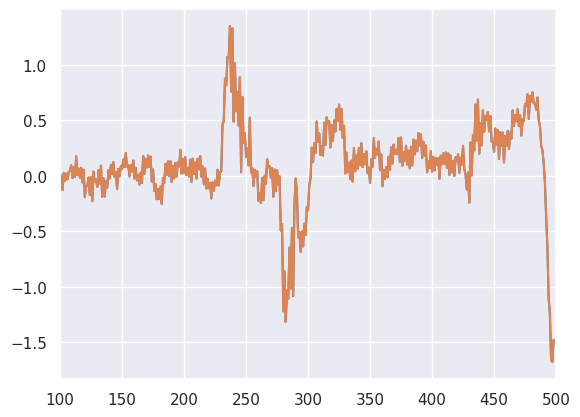

In [215]:
plt.plot(feature_array_cloud[757:757+500, 0, 0])
plt.plot(feature_array_local[0:500, 0, 0])

plt.xlim(100, 500)

In [198]:
np.array_equal(feature_array_cloud[757+50:757:4757, :, :], feature_array_local[50:4000, :, :])

False

In [126]:
grids = test_create_grids(of_params.img_shape, of_params.grid_size)

args = grids, of_params.window_size, of_params.stop_steps

of_left = []
of_right = []

prev_left = []
curr_left = []

prev_right = []
curr_right = []

cnt_left = 0
cnt_right = 0
ts = []

for i in range(1, 10001):
    print(i)
    if i % 2 == 1:
        cnt_left += 1
        prev_left.append(np.load("/users/tom/images/img_prev%d.npy" %i, allow_pickle=True))
        curr_left.append(np.load("/users/tom/images/img_curr%d.npy" %i, allow_pickle=True))

        of_left.append(test_cv2_calcOpticalFlowPyrLK(prev_left[cnt_left-1], curr_left[cnt_left-1], *args))
        ts.append(np.load("/users/tom/images/timestamps%d.npy" %i, allow_pickle=True))
    else:
        cnt_right += 1
        prev_right.append(np.load("/users/tom/images/img_prev%d.npy" %i, allow_pickle=True))
        curr_right.append(np.load("/users/tom/images/img_curr%d.npy" %i, allow_pickle=True))
        
        of_right.append(test_cv2_calcOpticalFlowPyrLK(prev_right[cnt_right-1], curr_right[cnt_right-1], *args))

feature_array_local = test_calculate_optical_flow(of_params, curr_left, curr_right)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [90]:
print("Input frames cloud are equal to downloaded frames (left): %s" %str(np.array_equal(np.array(curr_left)[0:5000, :, :], images_left_resized_cloud[0:5000, :, :])))

print("Input frames cloud are equal to downloaded frames (right): %s" %str(np.array_equal(np.array(curr_right)[0:4999, :, :], images_right_resized_cloud[0:4999, :, :])))

print("Input frames cloud are equal to to locally computed frames (left): %s" %str(np.array_equal(np.array(curr_left)[758:758+4000, :, :], img_l_resized_local[0:4000, :, :])))

print("Input frames cloud are equal to locally computed frames (right): %s" %str(np.array_equal(np.array(curr_right)[758:758+4000, :, :], img_r_resized_local[0:4000, :, :])))

Input frames cloud are equal to downloaded frames (left): True
Input frames cloud are equal to downloaded frames (right): True
Input frames cloud are equal to to locally computed frames (left): True
Input frames cloud are equal to locally computed frames (right): True


In [143]:
np.argmin(abs(np.mean(curr_right - prev_right[7], axis=(1, 2))))

1

In [142]:
left_images_prev = np.load("/users/tom/images/left_images_prev.npy")

np.argmin(abs(np.mean(curr_left - left_images_prev[7], axis=(1, 2))))

0

In [114]:
feature_array_local = np.array(feature_array_local)
of_left = np.array(of_left)

(-5.0, 12.0)

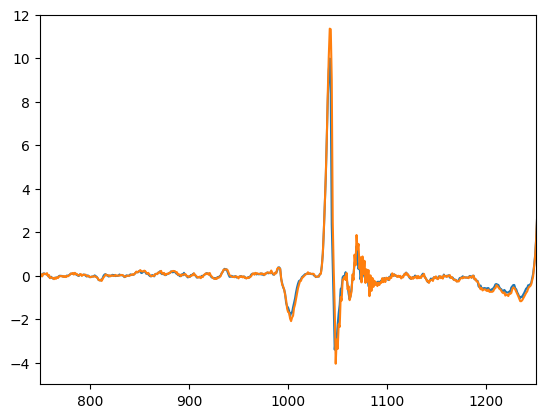

In [124]:
import matplotlib.pyplot as plt
plt.plot(of_left[0:, 1, 1])
# plt.plot(feat_arr[0:, 1, 1])
plt.plot(feature_array_local[:, 1, 1])
plt.xlim(750, 1250)
plt.ylim(-5, 12)

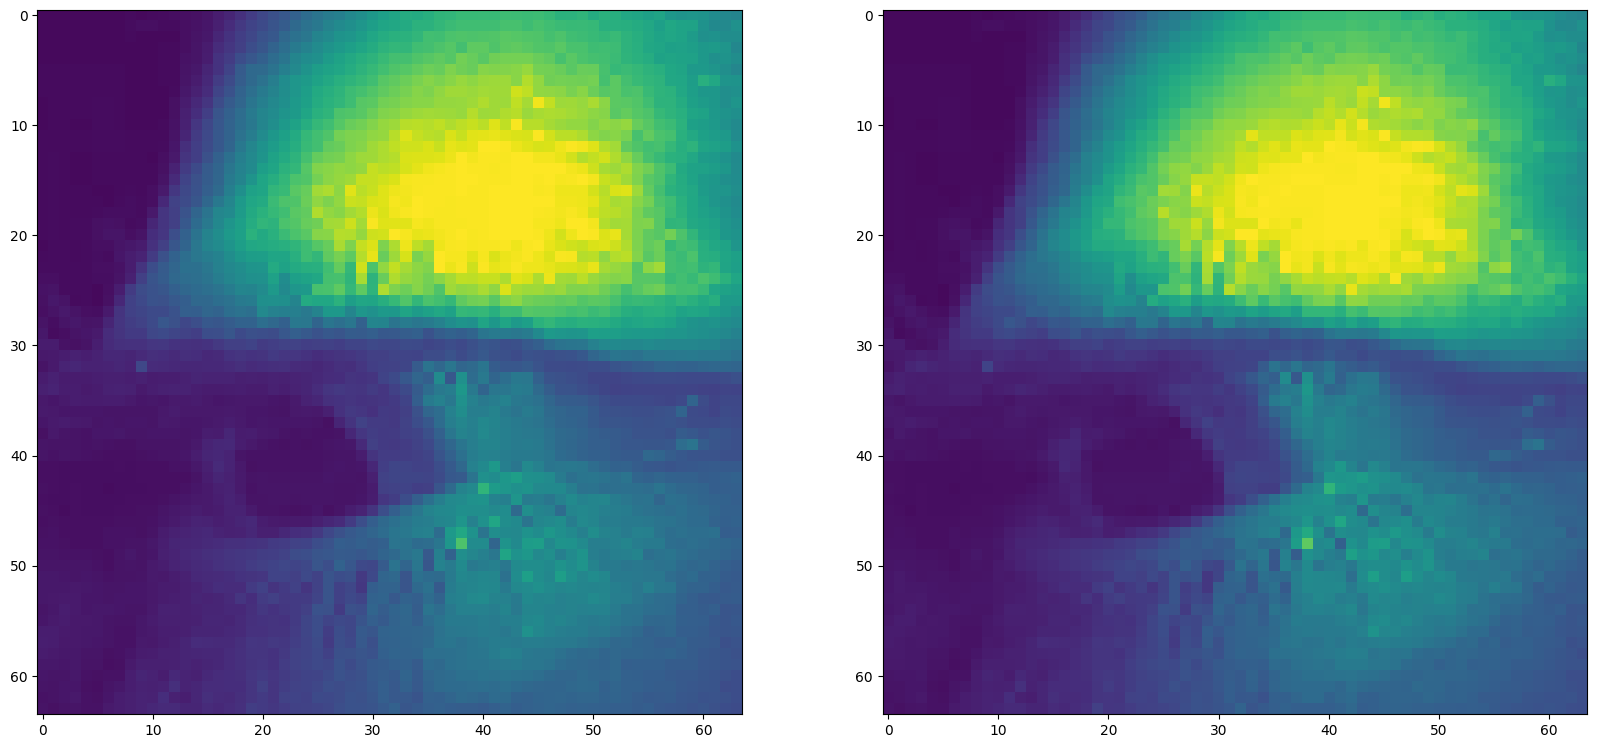

In [15]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(prev_right[766], vmin=0, vmax=255)
ax[1].imshow(img_r_resized_local[0], vmin=0, vmax=255)

NameError: name 'img_l_resized_cloud' is not defined

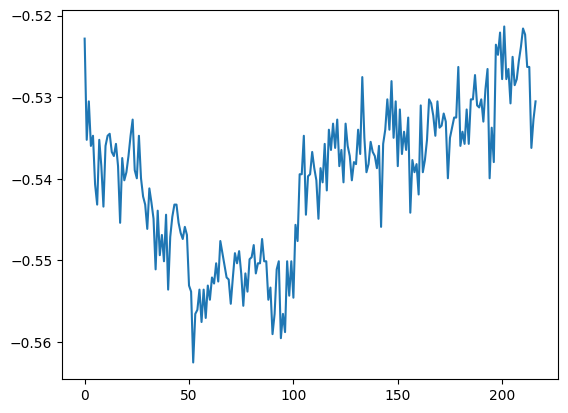

In [16]:
plt.plot(np.diff(prev_left)[766:].mean(axis=1).mean(axis=1))
plt.plot(np.diff(img_l_resized_cloud).mean(axis=1).mean(axis=1))
plt.xlim(4000, 4500)

In [240]:
i = 3500

np.mean(prev_left[i+761] - images_left_resized_cloud[i], axis=(0,1))

10.508789

AttributeError: 'list' object has no attribute 'shape'

In [144]:
from more_itertools import windowed

In [153]:
ind = np.arange(0, 100, 1)

for i in windowed(ind, 7):

    print(i)

(0, 1, 2, 3, 4, 5, 6)
(1, 2, 3, 4, 5, 6, 7)
(2, 3, 4, 5, 6, 7, 8)
(3, 4, 5, 6, 7, 8, 9)
(4, 5, 6, 7, 8, 9, 10)
(5, 6, 7, 8, 9, 10, 11)
(6, 7, 8, 9, 10, 11, 12)
(7, 8, 9, 10, 11, 12, 13)
(8, 9, 10, 11, 12, 13, 14)
(9, 10, 11, 12, 13, 14, 15)
(10, 11, 12, 13, 14, 15, 16)
(11, 12, 13, 14, 15, 16, 17)
(12, 13, 14, 15, 16, 17, 18)
(13, 14, 15, 16, 17, 18, 19)
(14, 15, 16, 17, 18, 19, 20)
(15, 16, 17, 18, 19, 20, 21)
(16, 17, 18, 19, 20, 21, 22)
(17, 18, 19, 20, 21, 22, 23)
(18, 19, 20, 21, 22, 23, 24)
(19, 20, 21, 22, 23, 24, 25)
(20, 21, 22, 23, 24, 25, 26)
(21, 22, 23, 24, 25, 26, 27)
(22, 23, 24, 25, 26, 27, 28)
(23, 24, 25, 26, 27, 28, 29)
(24, 25, 26, 27, 28, 29, 30)
(25, 26, 27, 28, 29, 30, 31)
(26, 27, 28, 29, 30, 31, 32)
(27, 28, 29, 30, 31, 32, 33)
(28, 29, 30, 31, 32, 33, 34)
(29, 30, 31, 32, 33, 34, 35)
(30, 31, 32, 33, 34, 35, 36)
(31, 32, 33, 34, 35, 36, 37)
(32, 33, 34, 35, 36, 37, 38)
(33, 34, 35, 36, 37, 38, 39)
(34, 35, 36, 37, 38, 39, 40)
(35, 36, 37, 38, 39, 40, 41)
(36, 